# Underway quick look at files

Load the data and make some plots and stuff using `kval`'s built-in functionality (basic stuff for now).

In [45]:
# Load the ctd module from the kval library  
from kval.data import ctd
import glob2

# for data manipualtion
import pandas as pd
import xarray as xr
import numpy as np

# for custom plotting
import matplotlib.pyplot as plt
# Set the matplotlib backend so we can interact with the plots (zoom, click buttons etc)
%matplotlib widget

## Load data from `.cnv`s

In [15]:
# Get a list of the processed CTD-data files
cnv_list_all = glob2.glob('../../../../proc/*.cnv')

# Get lists of binne and unbinned data, respectively
cnv_list_bin = [file for file in cnv_list_all if '_bin' in file]
cnv_list_nbin = [file for file in cnv_list_all if not  '_bin' in file]

In [16]:
# Load the CTD data as joined xarray dataset
# ds = ctd.ctds_from_cnv_dir('../../../../proc/')
ds_ctd = ctd.ctds_from_cnv_list(cnv_list_bin, station_from_filename=False)

# manually fix station name (string entered when starting the data recording, should have been statio number only)
ds_ctd.STATION[2] = '83'
ds_ctd.STATION[3] = '84'

NOTE!: 72: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 74: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0083: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0084: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 95: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 106: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 113: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 118: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 127: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 132: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 133: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
Loaded 11 profiles from l

Joining profiles together:   0%|          | 0/11 [00:00<?, ?it/s]

In [17]:
# load logsheet into pandas data frame for meta data; later used for coordinate matching of the stations and bottle value avearging
df_log = pd.read_excel('../../../../logsheets/iC3_field_school_samplelog_marine_clean.xlsx', sheet_name='samplelog')[
    ['decimalLatitude', 'decimalLongitude', 'bottomDepthInMeters', 'locationID', 'gearType', 'niskinNumber', 'maximumDepthInMeters','sampleType']]

# extract numerical StationID from locatioID string using regexp
df_log['STATION'] = df_log.locationID.str.extract('(^\d*)')

# extract geographical coordinates logsheet data frame; remove duplicates & swap dimensions
df_loc_all = df_log.drop_duplicates(subset=['decimalLatitude', 'decimalLongitude', 'STATION']).dropna(subset=['decimalLatitude'])
df_loc = df_loc_all[['STATION', 'decimalLatitude', 'decimalLongitude']]
# convert location data frame into dataset and insert values into cnv dataset
ds_loc = xr.Dataset(df_loc)
ds_loc = ds_loc.swap_dims({'dim_0': 'STATION'})

# Make `STATION` a coordinate in the CTD dataset for combining with position data.
ds_ctd = ds_ctd.swap_dims({'TIME': 'STATION'})
ds_ctd['LATITUDE']=ds_loc.decimalLatitude
ds_ctd['LONGITUDE']=ds_loc.decimalLongitude

# swap coordinates back for use with plotting fucntions in kval
ds_ctd = ds_ctd.swap_dims({'STATION':'TIME'})

C:\Users\hattermann\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [18]:
# Do some standard tweaks to metadata (not necessarily ideal formatting)
ds_ctd = ctd.metadata_auto(ds_ctd)

#### Look at the file 

Click-browse through variables and attributes to see that everything looks good.

## Quick looks
Note: Good practice to close the plots when you are done. Otherwise, they still take up memory.

#### Look at profile locations on a map

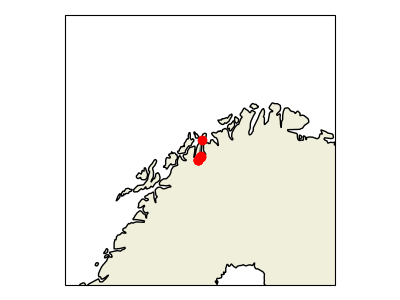

In [19]:
ctd.map(ds_ctd)

#### Look at some contours of the data

Use the interactive functionality to look through variables etc.

In [20]:
ctd.contour(ds_ctd)

#### Inspect individual profiles

In [21]:
ctd.inspect_profiles(ds_ctd)

There is a weird spike to low salinities in profile 8. That one should be corrected manually.

Now, let's make your own T-S diagram for water mass identification

For more fancy stuff, explore: https://xoa.readthedocs.io/en/develop/api/xoa.plot.plot_ts.html from https://xoa.readthedocs.io

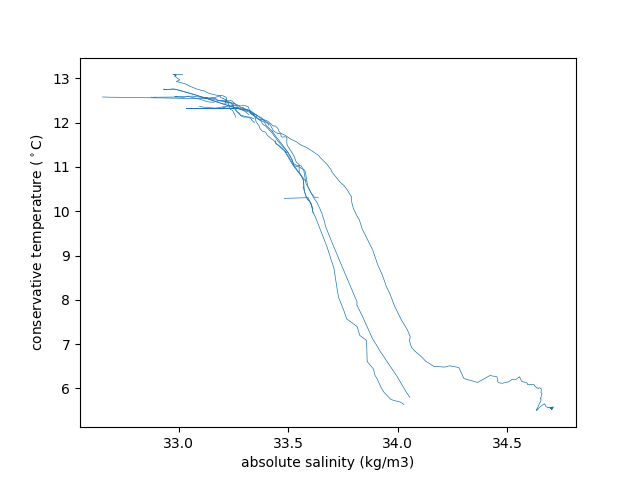

In [56]:
fig, ax = plt.subplots()

# Plot all profiles on to p of each other
for nn in np.arange(ds_ctd.sizes['TIME']):
    x = ds_ctd['gsw_saA'].isel(TIME=nn, drop=True).squeeze()
    y = ds_ctd['gsw_ctA'].isel(TIME=nn, drop=True).squeeze()
    ax.plot(x, y, color='tab:blue', lw=0.5, alpha=1)

ax.set_xlabel('absolute salinity (kg/m3)')
ax.set_ylabel('conservative temperature ($^\circ$C)')

plt.show()

### Export to .netcdf and .mat format

Next we export the data to commonly used netcdf format. Note that we haven't really applied any post-processing steps, just joined the profiles and added some metadata. Since no quality control/ processing has been applied yet, we use a preliminary filename (unprocessed). Use the "Editing.ipynb" notebook to read the netcdf fiel and further process the data.  In case it is useful the dataset can also be exported for analysis in Matlab.

In [58]:
cruise_ctd_id = 'iC3-24-3-BP'
ds_ctd.attrs['id'] = cruise_ctd_id

nc_initial_dir = '../../../../netcdf'
ctd.to_netcdf(ds_ctd, nc_initial_dir, file_name = f'{cruise_ctd_id}_unprocessed')

Updated history attribute. Current content:
---
2024-09-09 to 2024-09-13: Data collection.
2024-09-11 to 2024-09-13: Processed to .cnv using SBE software (details in "PROCESSING.SBE_processing").
2024-09-15: Post-processing.
2024-09-15: Creation of this netcdf file.
---
Exported netCDF file as: ..\..\..\..\netcdf\iC3-24-3-BP_unprocessed.nc


### Check the NetCDF
Load the nc file we just created and inspect it.

In [ ]:
ds_load = ctd.from_netcdf(nc_initial_dir + f'{cruise_ctd_id}_unprocessed.nc')

In [12]:
mat_dir = '../../../../mat/'
ctd.to_mat(ds_ctd, mat_dir + 'ctd_data_unprocessed', simplify = True)

Dropped these variables from the Dataset: PROCESSING.
Saved the (simplified) Dataset to: ../../../../mat/ctd_data_unprocessed.mat


## Compute Bottle averages

Somewhere should also be a block of code to extract bottle averages

Probably, it also makes sense to fill in upper part of profile 10 with data from profile 9, as these are taken at the same location shortly after each other.

In [ ]:
############# FIXME:
# Add bottle value averaging here: use logsheet dataframe to extract bottle depths, extract averages 
